In [41]:
from glob import glob
from scipy.stats import ttest_ind

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import json

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler


In [2]:
files = glob('./generic_search_data/*.csv')

file_dict = {}

dfs = []
    
for i in range(len(files)):
    file = open(files[i], 'r', encoding='utf-8')
    lines = file.readlines()[1:]
    file_dict[i] = lines
    dfs.append(pd.read_csv(files[i]))
    


Choosing a random example from the data frames and seeing what it contains

In [3]:
dfs[3].head()

,Unnamed: 0,h3 filter,h2 filter,p filter,div filter,h1 filter,span filter,li filter,h3 coil,h2 coil,...,h1 repair,span repair,li repair,h3 maintenance,h2 maintenance,p maintenance,div maintenance,h1 maintenance,span maintenance,li maintenance
0,0,NaN,NaN,Every PTAC manufacturer recommends a complete ...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,PTACs are self contained and are installed thr...,NaN,NaN,Ductless Mini-Split Maintenance Guide,Ductless Mini-Split Maintenance Guide
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,PTAC Maintenance,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
removed_entries = []
for entry in file_dict:
    if not file_dict[entry]:
        removed_entries.append(entry)
        
for element in removed_entries:
    file_dict.pop(element)

In [5]:
# array where each entry is the entire text for each link
raw_text = []

for entry in file_dict:
    string = ' '.join([str(item) for item in file_dict[entry]])
    raw_text.append(string)

In [6]:
def clean(text):
    text = re.sub(r"[^a-zA-Z]+", ' ', text)
    text = text.lower()
    return text


cleaned_text = list(map(lambda x: clean(x), raw_text))



In [7]:
print(cleaned_text[36])
print(cleaned_text[12])

 dave diy cleaning the filter on your ptac heating cooling unit 
 what exactly is a packaged unit and how is it different from the standard central ac heat pump often found in homes the conventional system is known as a split system because it uses separate indoor and outdoor cabinets the outdoor cabinet contains the compressor exhaust fan and refrigerant coil and the indoor cabinet houses the blower refrigerant coil and connection to the ductwork with a packaged unit everything is contained inside a single cabinet located outside which connects to the building s ventilation system with return and supply ducts all heat release and absorption occurs in this one unit and the conditioned air goes into the supply ducts of the home what exactly is a packaged unit and how is it different from the standard central ac heat pump often found in homes the conventional system is known as a split system because it uses separate indoor and outdoor cabinets the outdoor cabinet contains the compressor

Making the vectorizer

In [8]:
vectorizer = CountVectorizer(binary=True)

features = vectorizer.fit_transform(cleaned_text)

Scaling the data, have to turn off with_mean because we are working with a very sparse matrix

In [9]:
scaler = StandardScaler(with_mean=False)
scaled_data = scaler.fit_transform(features)

In [10]:
svd = TruncatedSVD(n_components=5)
decomp = svd.fit_transform(scaled_data)

Looks like the first and third components yield the highest amount of variance

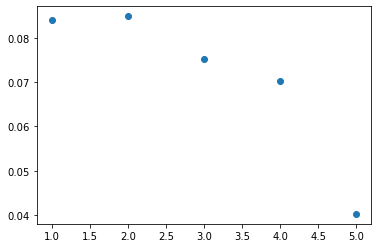

In [11]:
plt.scatter([1, 2, 3, 4, 5], svd.explained_variance_ratio_)

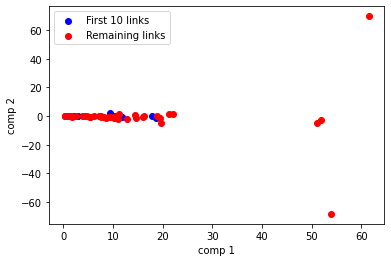

In [12]:
plt.scatter(decomp[:10,0], decomp[:10,1], color='blue', label='First 10 links')
plt.scatter(decomp[10:,0], decomp[10:,1], color='red', label='Remaining links')
plt.legend()
plt.xlabel('comp 1')
plt.ylabel('comp 2');

In [13]:
temp = decomp[10:,0]
indexes = []
for i in range(len(temp)):
    if temp[i] > 25:
        indexes.append(i)


print(indexes)
new_decomp_x = np.delete(decomp[10:,0], indexes)
new_decomp_y = np.delete(decomp[10:,1], indexes)

[10, 12, 22, 36]


In [14]:
first_ten_x = decomp[:10,0].sum()/len(decomp[:10,0])

first_ten_y = decomp[:10,1].sum()/len(decomp[:10,1])


remaining_x = new_decomp_x.sum()/len(new_decomp_x)
remaining_y = new_decomp_y.sum()/len(new_decomp_y)

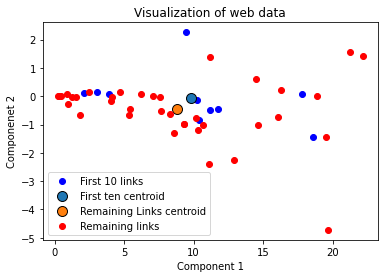

In [15]:
plt.scatter(decomp[:10,0], decomp[:10,1], color='blue', label='First 10 links')
plt.scatter(first_ten_x, first_ten_y, label='First ten centroid', s=100, edgecolor='k')
plt.scatter(remaining_x, remaining_y, label='Remaining Links centroid', s=100, edgecolor='k')
plt.scatter(new_decomp_x, new_decomp_y, color='red', label='Remaining links')
plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Componenet 2')
plt.title('Visualization of web data');

In [47]:
first_centroid = np.array([first_ten_x, first_ten_y])
second_centroid = np.array([remaining_x, remaining_y])


remaining_links = np.hstack((new_decomp_x.reshape(37,1), new_decomp_y.reshape(37,1)))


first_distances = np.linalg.norm(decomp[:10,:2] - first_centroid, axis=1)
second_distances = np.linalg.norm(remaining_links - second_centroid, axis=1)

_, p = ttest_ind(first_distances, second_distances)

print("P-value of t test: " + str(p))


P-value of t test: 0.451881333587025
